In [3]:
from shared import graph, stats_utils
from src_draft.utils import LOW_IMP_FEATURES
import shared.ml_config_core as ml_config_core
import pandas as pd
from shared.ml_config_core import ModelConfigsCollection
from shared.ml_config_runner import run_tuning_for_configs_collection
from shared.definitions import TuningResult

from Draft import feature_builder_v2

import importlib
from matplotlib import pyplot as plt
import src_draft.utils as shared_utils
import seaborn as sns

In [4]:
importlib.reload(shared_utils)

shared_utils.pandas_config(pd)
shared_utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [5]:
features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True,
                                                                        ds_type=feature_builder_v2.DatasetType.FULL)


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
Full DS size: 307511


In [6]:
features_matrix_only_high_imp = features_matrix[shared_utils.HIGH_IMP_FEATURES]
features_matrix_any_imp = features_matrix[shared_utils.ANY_IMP_FEATURES]


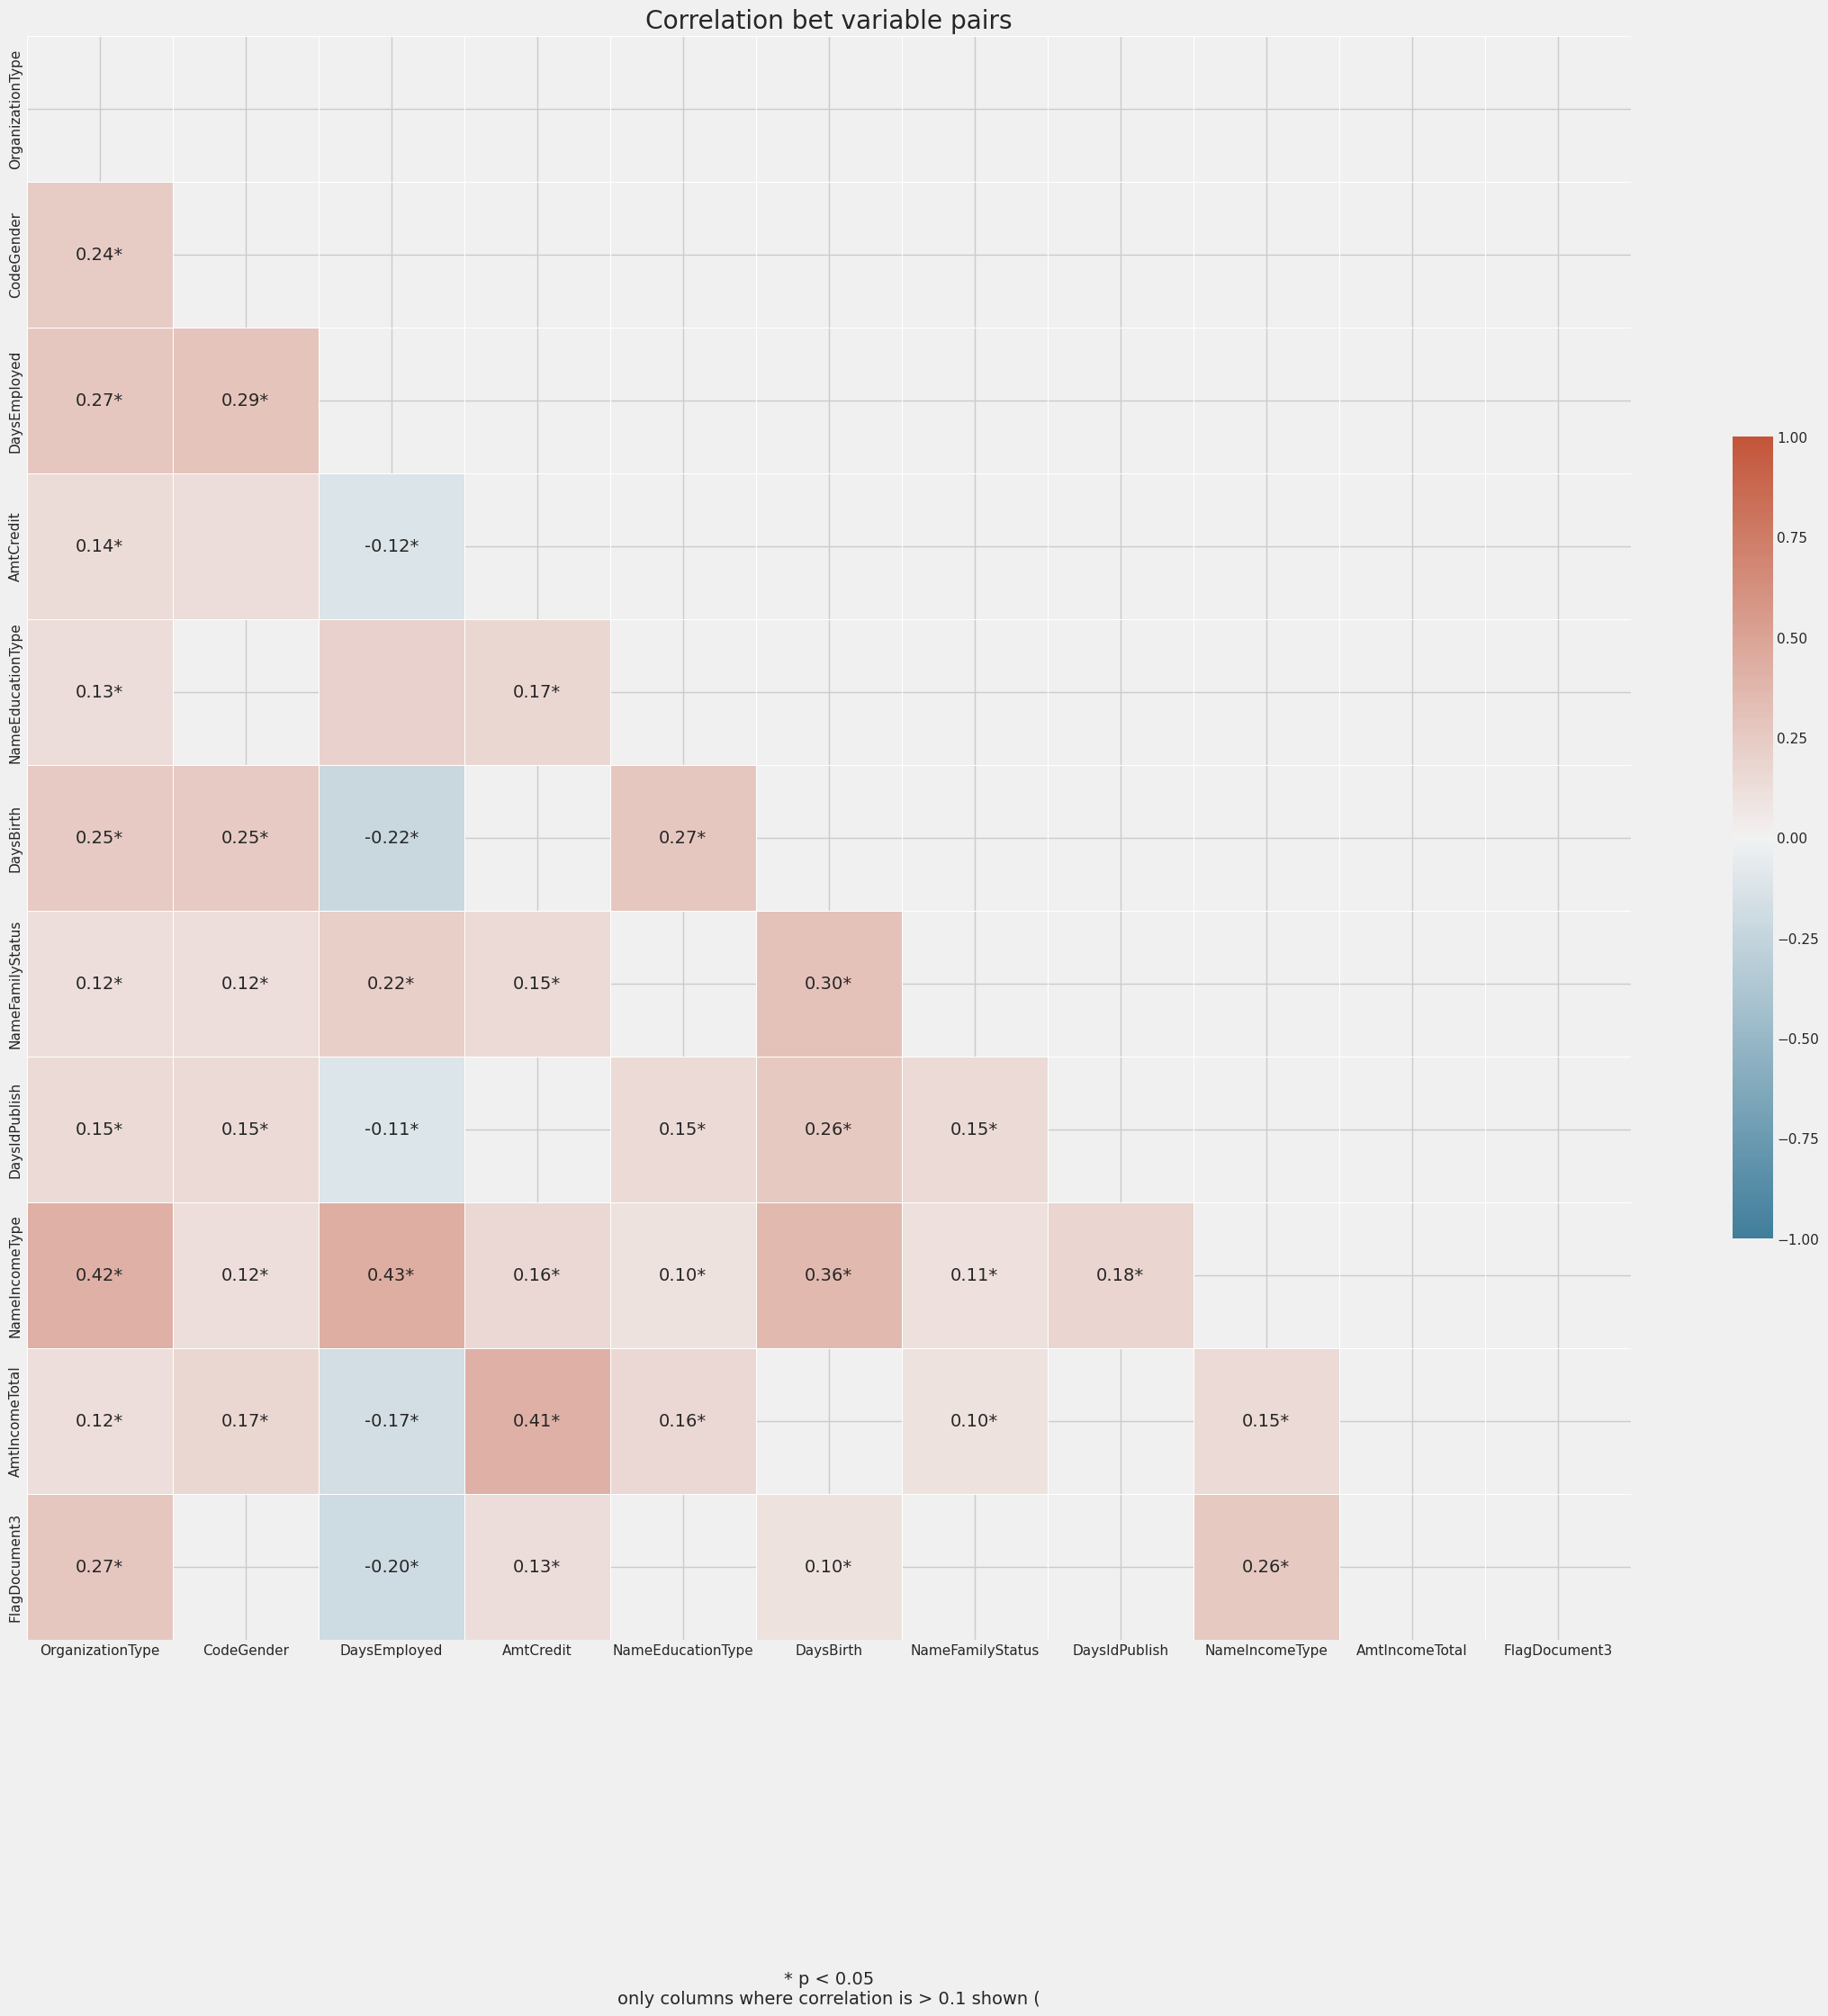

In [7]:
importlib.reload(graph)

graph.render_corr_matrix_based_on_type(features_matrix_only_high_imp.dropna(axis=1, how="any"))
# TODO: 

In [10]:
# features_matrix_only_imp.dtypes

features_matrix_only_imp_cat_cols = features_matrix.select_dtypes(include='category').columns
print(len(features_matrix_only_imp_cat_cols))

22


In [8]:
features_matrix_target_cat = features_matrix.copy()
features_matrix_target_cat["TARGET"] = features_matrix_target_cat["TARGET"].map(lambda x: "Defaulted" if x == 1 else "No Issues")

In [ ]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_target_cat,
    split_var="TARGET",
    include_cols=features_matrix_only_imp_cat_cols,
)



In [15]:
stats_utils.nan_summary(features_matrix[["ExtSource1", "ExtSource2", "ExtSource3"]])

,Total NaN Values,Proportion NaN (%)
ExtSource1,173378,56.0
ExtSource2,660,0.0
ExtSource3,60965,20.0


In [17]:
features_matrix[["ExtSource1", "ExtSource2", "ExtSource3"]].describe().round(3)

,ExtSource1,ExtSource2,ExtSource3
count,134133.000,306851.000,246546.000
mean,0.502,0.514,0.511
std,0.211,0.191,0.195
min,0.015,0.000,0.001
25%,0.334,0.392,0.371
50%,0.506,0.566,0.535
75%,0.675,0.664,0.669
max,0.963,0.855,0.896


Text(0.5, 1.025, 'Grade and Interest Rate')

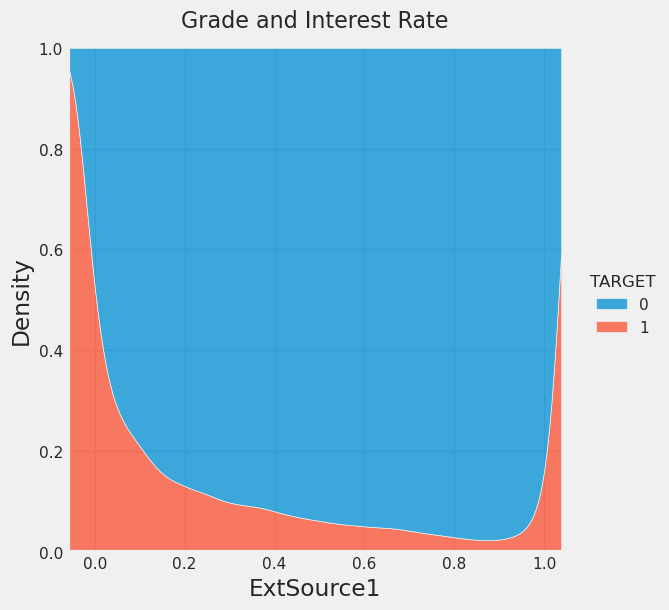

In [11]:
sns.displot(
    data=features_matrix,
    x="ExtSource1",
    hue="TARGET",
    kind="kde",
    height=6,
    multiple="fill",
    # clip=(10, 80),
)
plt.title("Default Rate and EXT_SOURCE_1", x=0.5, y=1.025, fontdict={"size": 16})

Text(0.5, 1.025, 'Default Rate and EXT_SOURCE_2')

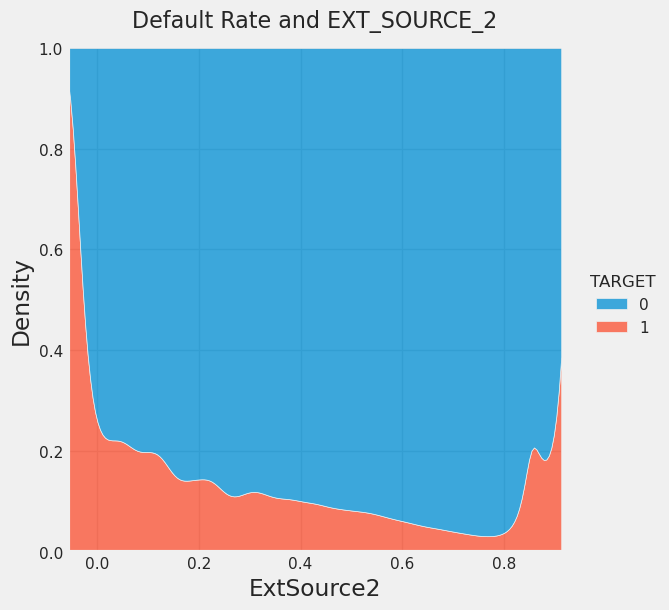

In [12]:
sns.displot(
    data=features_matrix,
    x="ExtSource2",
    hue="TARGET",
    kind="kde",
    height=6,
    multiple="fill",
    # clip=(10, 80),
)
plt.title("Default Rate and EXT_SOURCE_2", x=0.5, y=1.025, fontdict={"size": 16})

Text(0.5, 1.025, 'Default Rate and EXT_SOURCE_3')

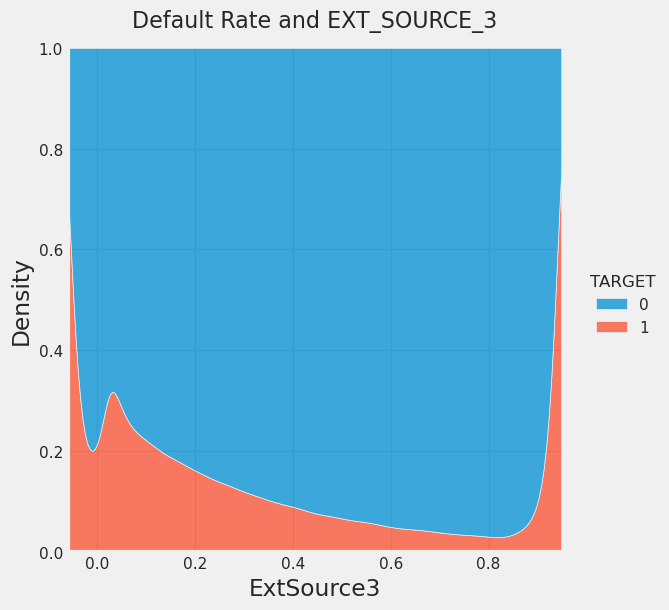

In [13]:
sns.displot(
    data=features_matrix,
    x="ExtSource3",
    hue="TARGET",
    kind="kde",
    height=6,
    multiple="fill",
    # clip=(10, 80),
)
plt.title("Default Rate and EXT_SOURCE_3", x=0.5, y=1.025, fontdict={"size": 16})

Text(0.5, 1.025, 'Default Rate and Credit Amount')

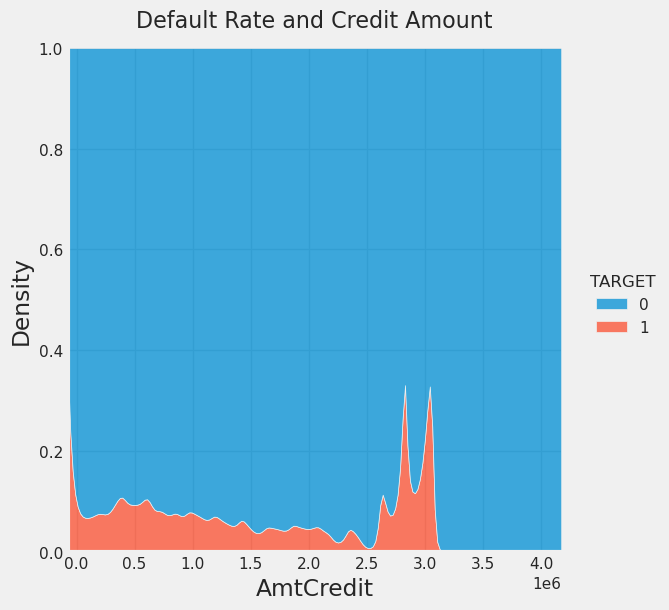

In [73]:
sns.displot(
    data=features_matrix,
    x="AmtCredit",
    hue="TARGET",
    kind="kde",
    height=6,
    multiple="fill",
    # clip=(0.0, 4),
)
plt.title("Default Rate and Credit Amount", x=0.5, y=1.025, fontdict={"size": 16})

Text(0.5, 1.025, 'Default Rate and Credit Amount')

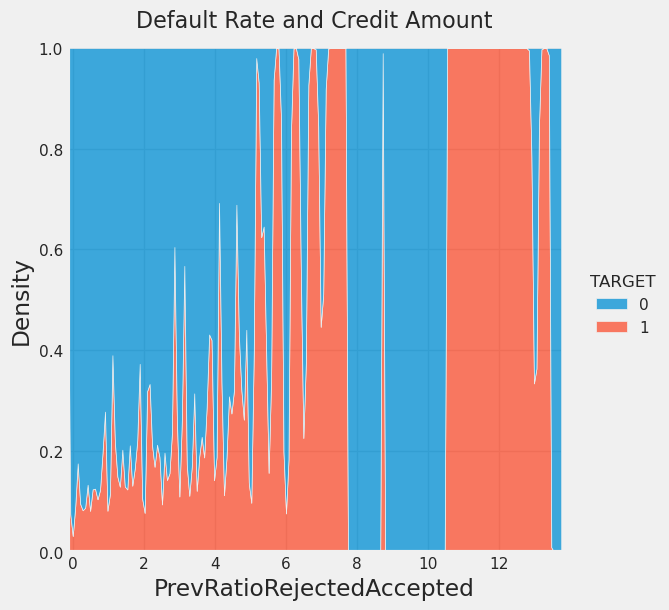

count    94755.000000
mean         0.202307
std          0.449392
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max         13.600000
Name: PrevRatioRejectedAccepted, dtype: float64

In [23]:
features_matrix_with_bins = features_matrix.copy()
numerical_cols = features_matrix_any_imp.select_dtypes(
    include=["int64", "float64", "Int64"]
).columns

for col in numerical_cols:
    if features_matrix_with_bins[col].nunique() < 5:
        features_matrix_with_bins[f"{col}_binned"] = features_matrix_with_bins[col].astype("category")
    else:
        features_matrix_with_bins[f"{col}_binned"] = stats_utils.bin_and_label(
            features_matrix_with_bins[col], num_bins=4
        )
    features_matrix_with_bins[col] = features_matrix_with_bins[col]


In [199]:
import numpy as np

conditions = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] <= 0.25,
    features_matrix["PrevRatioRejectedAccepted"] > 0.25
]

choices = ["No Previous App.", 'All Accepted',"< 25% Rejected", "> 25% Rejected"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["PrevRatioRejectedAccepted_cats"] = np.select(conditions, choices, default='No Previous App')

conditions = [
    features_matrix["TotalDefaults"] == 0,
    features_matrix["TotalDefaults"] >= 1,
    # features_matrix["TotalDefaults"] > 1
]

choices = ["No Defaults", '1 Defaulted Loans']#,"> 1 defaulted loan"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["TotalDefaults_cats"] = np.select(conditions, choices, default='WTF?').astype("object")

features_matrix_with_bins["Defaulted"] = features_matrix_with_bins["TARGET"].map(lambda x: "Yes" if x == 1  else "No")

In [163]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

All Accepted        62171
> 25% Rejected      22242
< 25% Rejected      10342
No Previous App.     5245
Name: PrevRatioRejectedAccepted_cats, dtype: int64

In [200]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()


No Defaults          98873
1 Defaulted Loans     1127
Name: TotalDefaults_cats, dtype: int64

In [165]:
features_matrix_with_bins["TotalDefaults"].value_counts()

0.0    98873
1.0     1065
2.0       47
3.0        6
4.0        4
6.0        3
5.0        1
7.0        1
Name: TotalDefaults, dtype: int64

In [152]:
features_matrix["PrevRatioRejectedAccepted"].describe()

count    94755.000000
mean         0.202307
std          0.449392
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max         13.600000
Name: PrevRatioRejectedAccepted, dtype: float64

### Previous Loan History and Default Risk

The chart below shows the default rate based on whether applicant has previous applied for loans with Home Cred:
`No Previous App.` - no previous applications for client found (i.e. new clients)
`All Accepted` - all previous applications were accepted
`< 25% Rejected` - less than 1/4 applications were rejected
`> 25% Rejected` - more than 1/4 applications were rejected

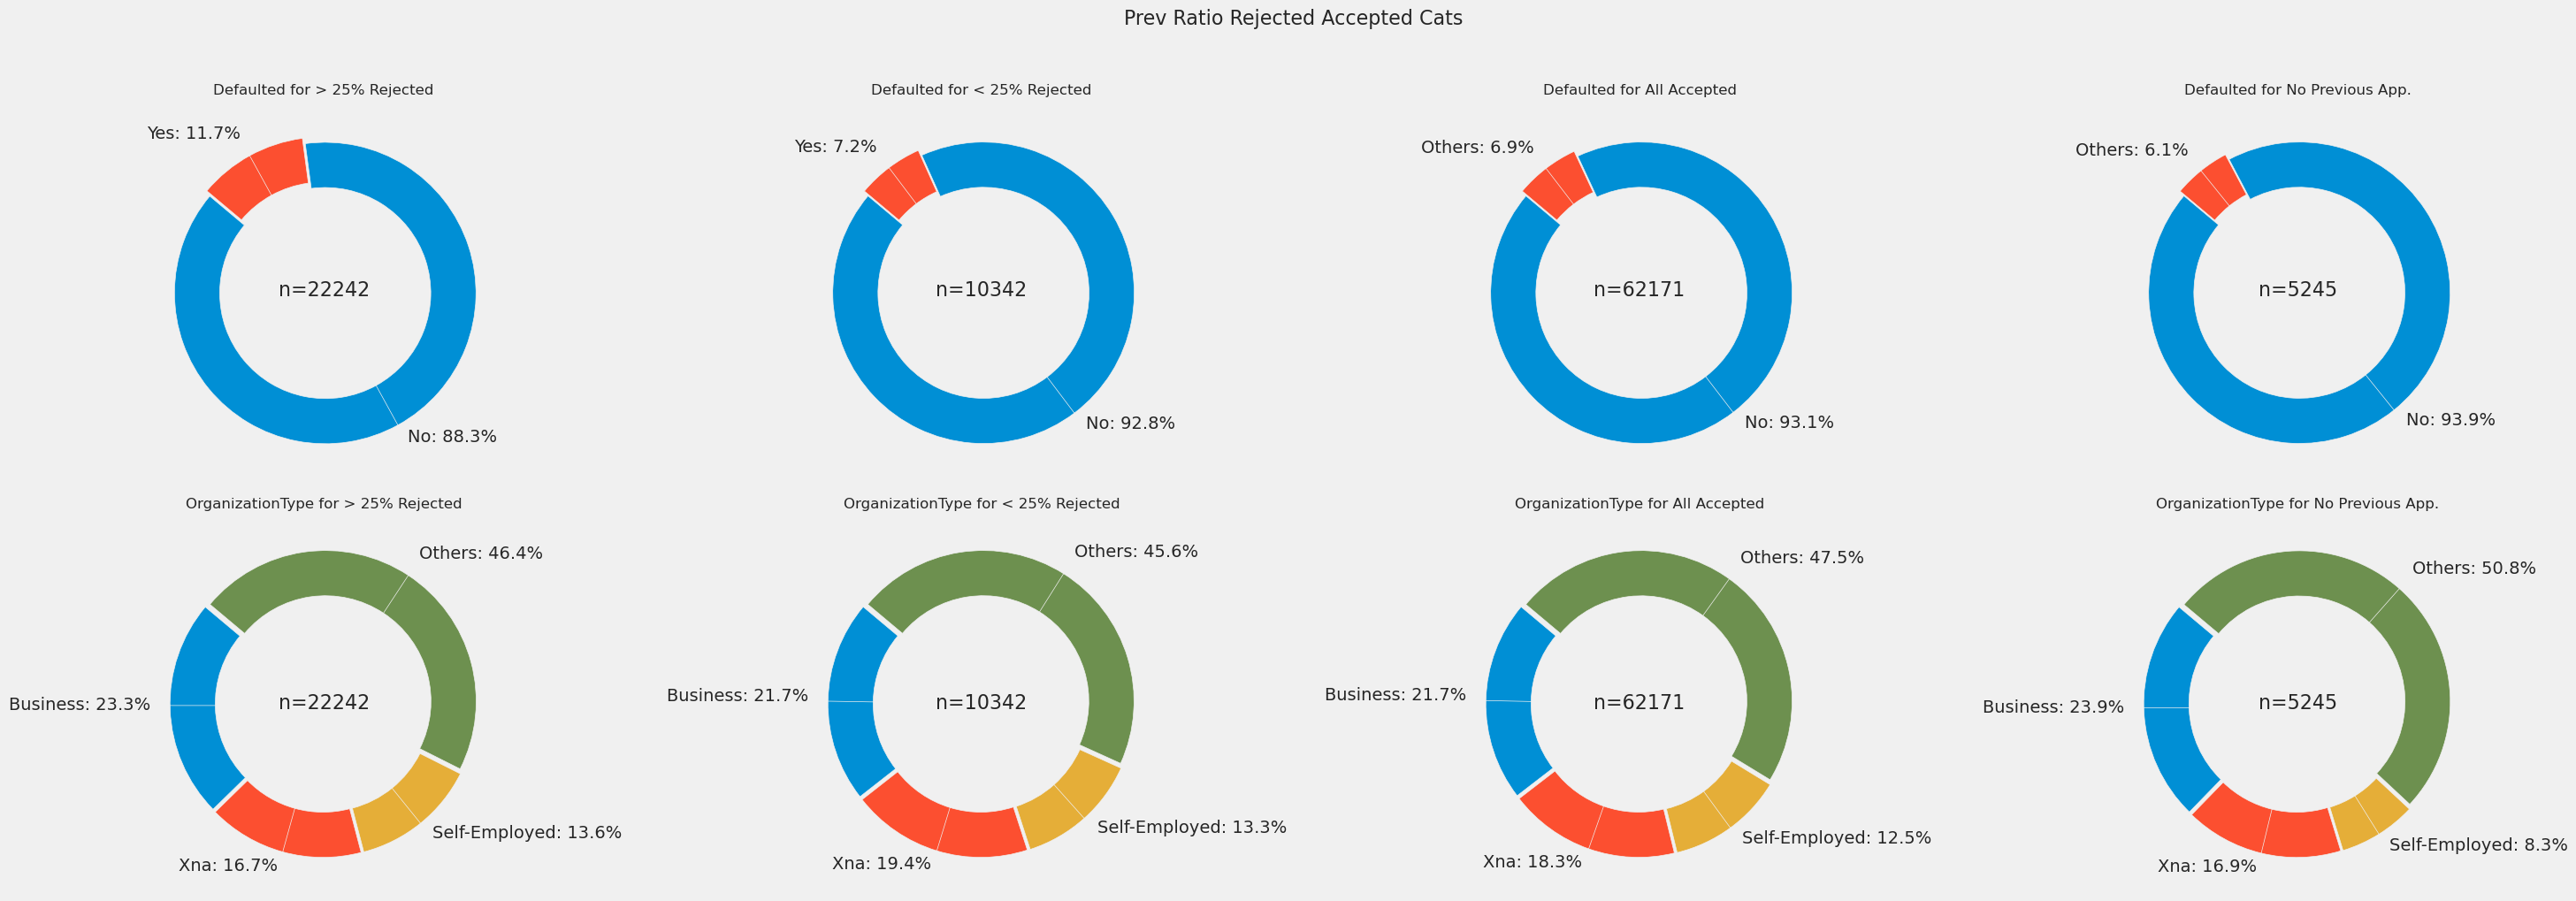

In [191]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_with_bins,
    split_var="PrevRatioRejectedAccepted_cats",
    include_cols=["Defaulted", "OrganizationType"],
)



In [196]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()

No Defaults           98873
1 Defaulted Loans      1065
> 1 defaulted loan       62
Name: TotalDefaults_cats, dtype: int64

In [195]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

All Accepted        62171
> 25% Rejected      22242
< 25% Rejected      10342
No Previous App.     5245
Name: PrevRatioRejectedAccepted_cats, dtype: int64

Interestingly we can see that while applicants whose previous loans were rejected are significantly more likely to default when finally given a loan previous clients with no failed applications have a higher default risk than new clients.

This likely limits the usefulness of the `previous_application` table because only a small proportion of clients have previously rejected applications

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


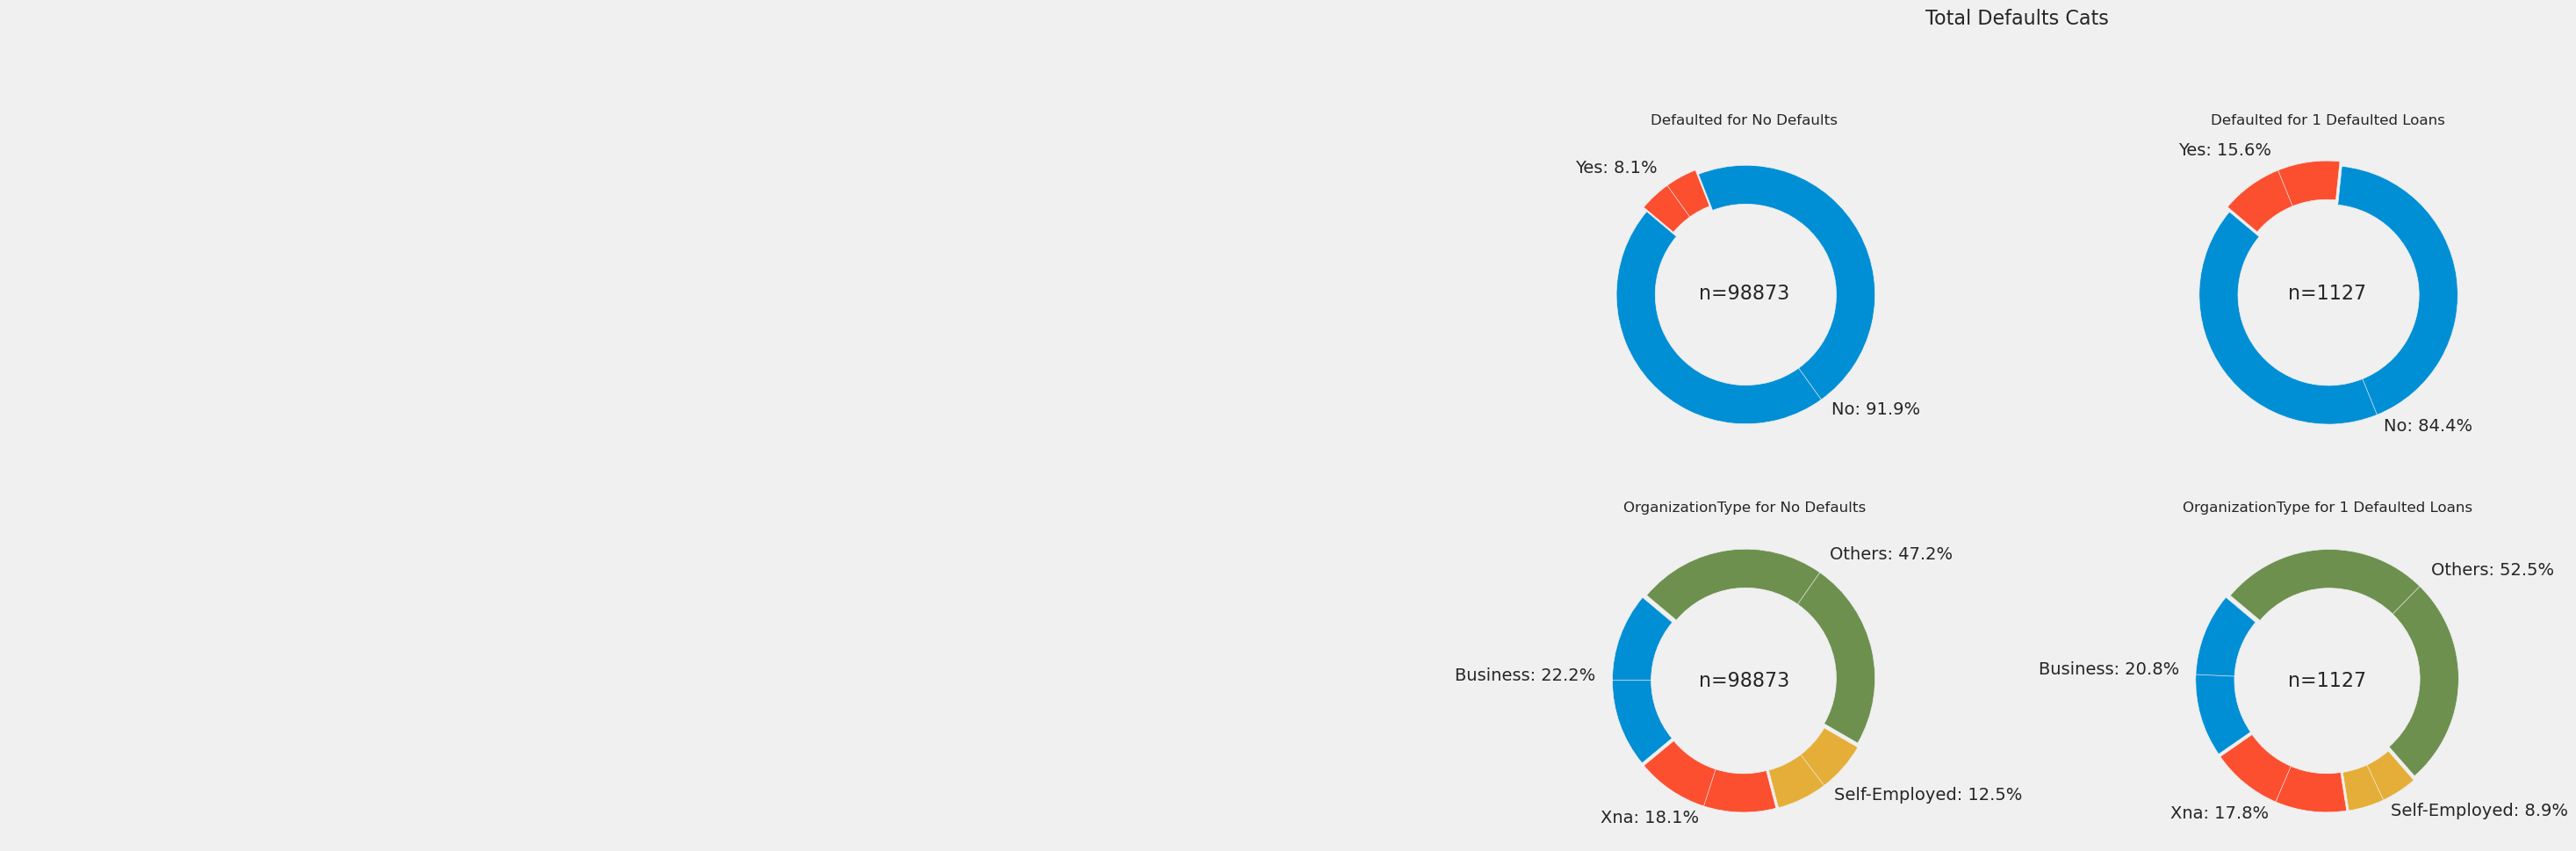

In [201]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_with_bins,
    split_var="TotalDefaults_cats",
    include_cols=["Defaulted", "OrganizationType"],
)



No Defaults           98873
1 Defaulted Loans      1065
> 1 defaulted loan       62
Name: TotalDefaults_cats, dtype: int64

In [161]:
features_matrix["TotalDefaults"].describe()

count    100000.000000
mean          0.012230
std           0.124018
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: TotalDefaults, dtype: float64

In [27]:
list(features_matrix_with_bins.columns)

['TARGET',
 'NameContractType',
 'CodeGender',
 'FlagOwnCar',
 'FlagOwnRealty',
 'CntChildren',
 'AmtIncomeTotal',
 'AmtCredit',
 'AmtAnnuity',
 'AmtGoodsPrice',
 'NameTypeSuite',
 'NameIncomeType',
 'NameEducationType',
 'NameFamilyStatus',
 'NameHousingType',
 'RegionPopulationRelative',
 'DaysBirth',
 'DaysEmployed',
 'DaysRegistration',
 'DaysIdPublish',
 'OwnCarAge',
 'FlagMobil',
 'FlagEmpPhone',
 'FlagWorkPhone',
 'FlagContMobile',
 'FlagPhone',
 'FlagEmail',
 'OccupationType',
 'CntFamMembers',
 'RegionRatingClient',
 'RegionRatingClientWCity',
 'WeekdayApprProcessStart',
 'HourApprProcessStart',
 'RegRegionNotLiveRegion',
 'RegRegionNotWorkRegion',
 'LiveRegionNotWorkRegion',
 'RegCityNotLiveCity',
 'RegCityNotWorkCity',
 'LiveCityNotWorkCity',
 'OrganizationType',
 'ExtSource1',
 'ExtSource2',
 'ExtSource3',
 'ApartmentsAvg',
 'BasementareaAvg',
 'YearsBeginexpluatationAvg',
 'YearsBuildAvg',
 'CommonareaAvg',
 'ElevatorsAvg',
 'EntrancesAvg',
 'FloorsmaxAvg',
 'FloorsminAvg'

In [61]:
shared_utils.ANY_IMP_FEATURES

['ExtSource2',
 'ExtSource3',
 'ExtSource1',
 'OrganizationType',
 'CodeGender',
 'DaysEmployed',
 'AmtCredit',
 'NameEducationType',
 'OccupationType',
 'OwnCarAge',
 'PrevCreditReceivedRequestedDiff',
 'DaysBirth',
 'PrevAmtDownPaymentSum',
 'MeanbureauamtCreditSumDebt',
 'NameFamilyStatus',
 'MaxbureaudaysCreditEnddate',
 'PrevAvgYieldGroup',
 'MeanbureauamtCreditMaxOverdue',
 'AmtGoodsPrice',
 'DaysLastPhoneChange',
 'PrevRatioRejectedAccepted',
 'DaysIdPublish',
 'AmtAnnuity',
 'NameIncomeType',
 'PrevLastLoanGoodsCategory',
 'AmtIncomeTotal',
 'FlagDocument3',
 'MaxbureaudaysCredit',
 'PrevAcceptedToTotalRatio',
 'MaxbureaudaysEnddateFact']

In [ ]:
graph.boxen_plots_by_category(
    source_df=features_matrix_with_bins,
    group_col="pass__purpose",
    target_col="pass__loan_amnt",
    title="Loan Amount by Purpose",
    x_label="Loan Amount",
)


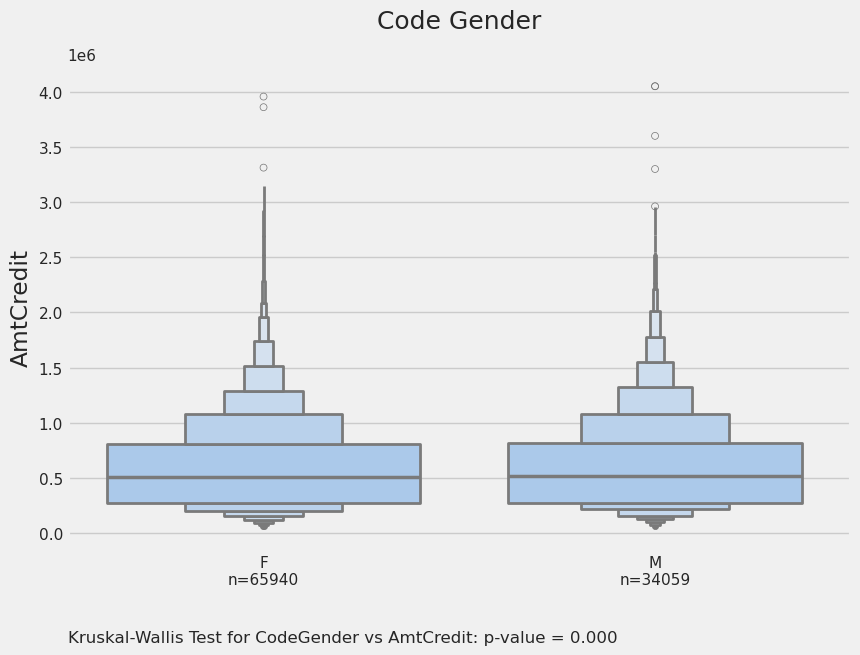

None

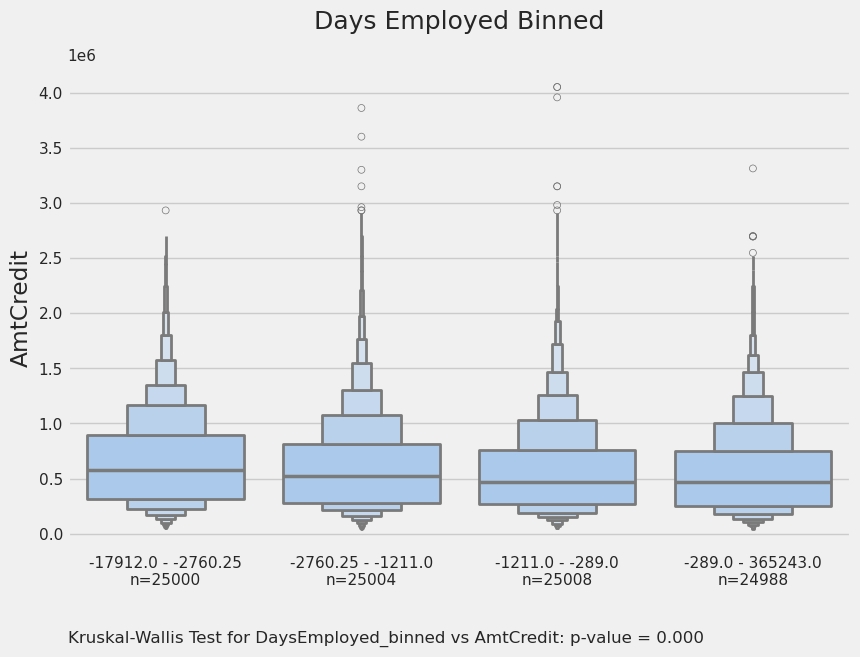

None

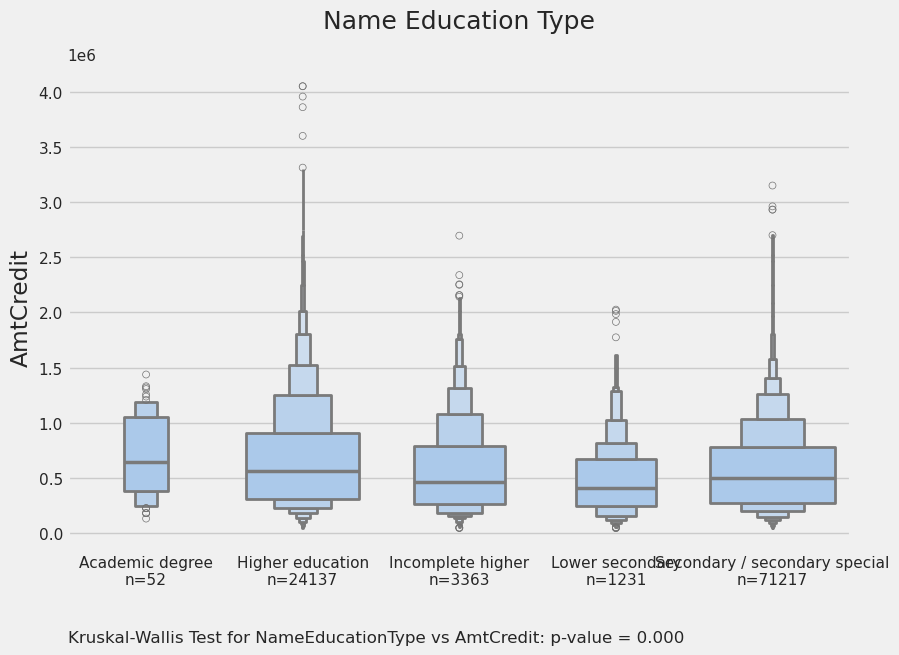

None

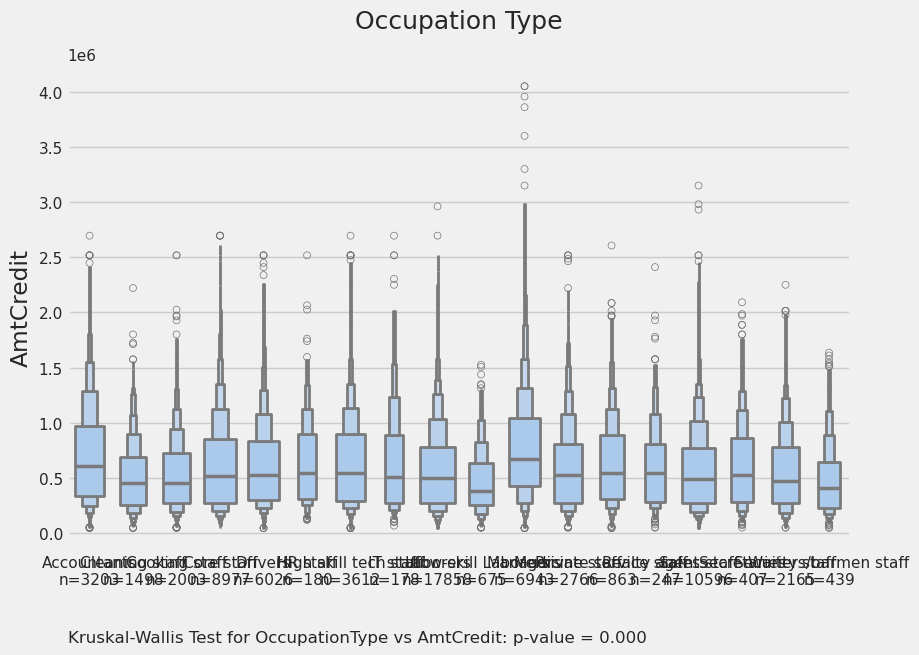

None

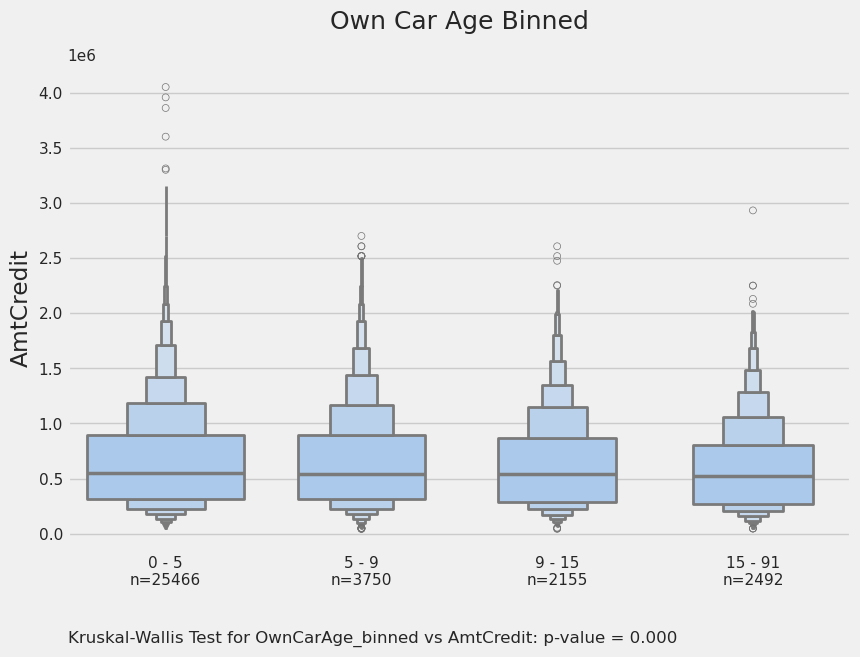

None

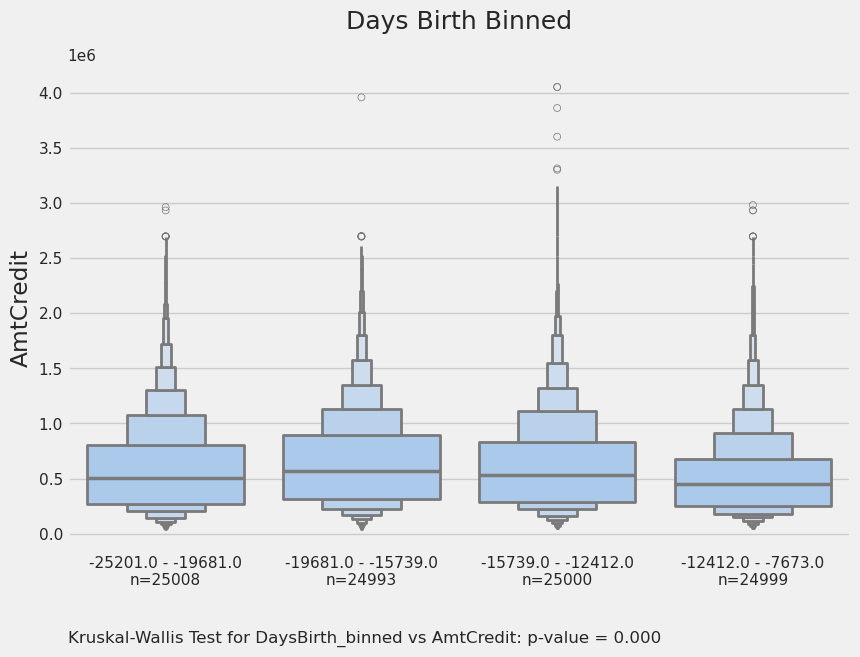

None

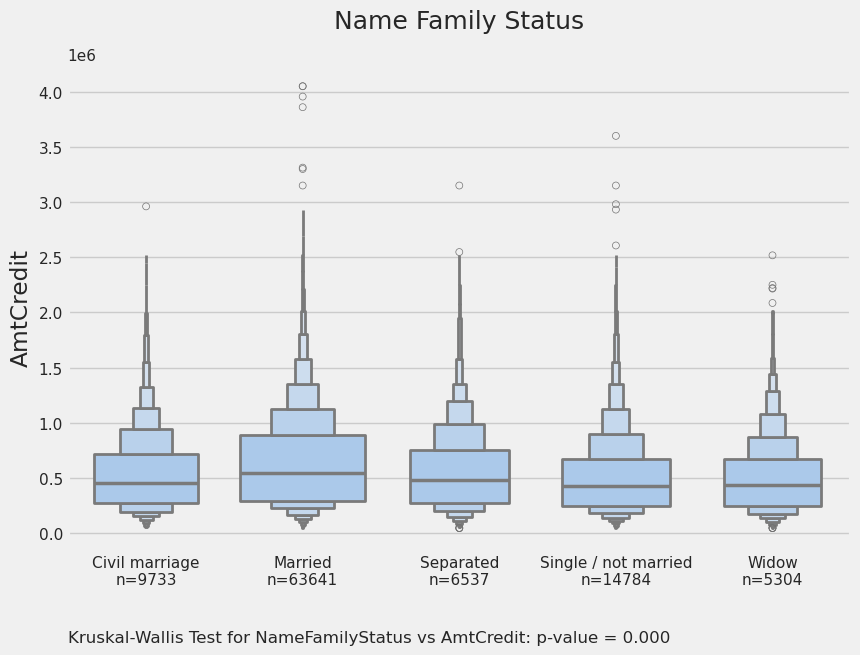

None

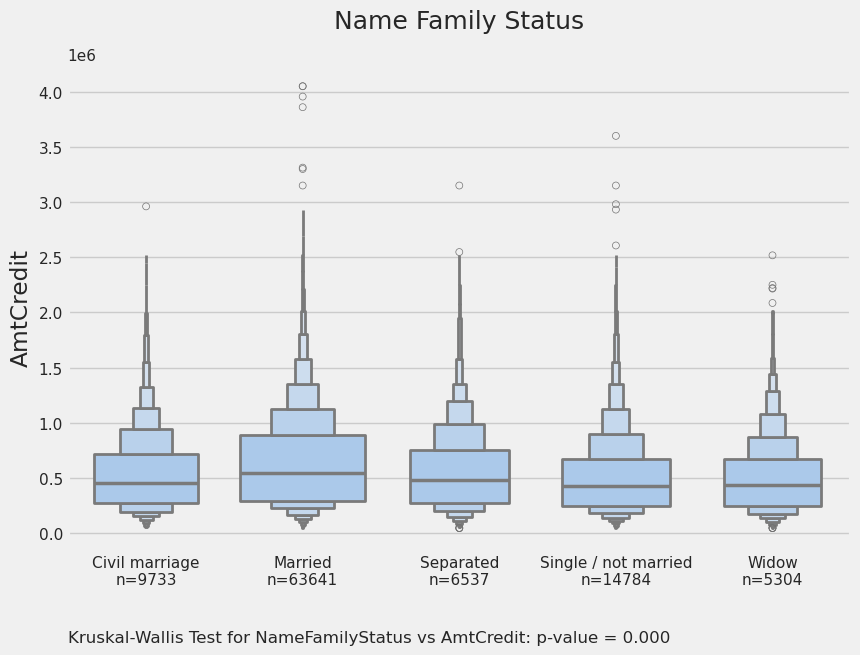

None

In [65]:
importlib.reload(graph)
for target_y in ["AmtCredit"]:
    for c in ["CodeGender", "DaysEmployed_binned", "NameEducationType", "OccupationType", "OwnCarAge_binned", 
              "DaysBirth_binned", "NameFamilyStatus" 
        , "NameFamilyStatus"]:
    # for c in features_matrix_with_bins.columns:
    #     if pd.api.types.is_numeric_dtype(features_matrix_with_bins[c]):
    #         continue
    #     
    #     for 
        display(graph.boxen_plot_by_cat(c, features_matrix_with_bins, target_y, drop_small_cats=True))
